In [2]:
import pandas as pd
import numpy as np
from graph_tool.all import *
from numpy.random import *
import time
import graph_tool as gt
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [193]:
#### helper functions ####
def read_tables_OpenROAD(data_root, design=None):
    # cell_edge_path = data_root  + design + "_cell_pin_edge.csv"
    # cell_path = data_root  + design + "_cell_properties.csv"
    # net_edge_path = data_root  + design + "_net_pin_edge.csv"
    # net_path = data_root  + design + "_net_properties.csv"
    # pin_edge_path = data_root  + design + "_pin_pin_edge.csv"
    # pin_path = data_root  + design + "_pin_properties.csv"
    # net_cell_edge_path = data_root  + design + "_cell_net_edge.csv"

    # all_fo4_delay_path = data_root + "all_fo4_delay_new.txt"

    #############
    ##add by BY##
    #############
    cell_cell_path = data_root + "cell_cell_edge.csv"
    #############


    cell_pin_path = data_root  + "cell_pin_edge.csv"
    cell_path = data_root  + "cell_properties.csv"
    net_pin_path = data_root  +  "net_pin_edge.csv"
    net_path = data_root  + "net_properties.csv"
    pin_pin_path = data_root  + "pin_pin_edge.csv"
    pin_path = data_root  + "pin_properties.csv"
    net_cell_path = data_root  + "cell_net_edge.csv"

    all_fo4_delay_path = data_root + "libcell_properties.csv"

    ### load tables
    # fo4_df = pd.read_table(all_fo4_delay_path, sep=',')
    fo4_df = pd.read_csv(all_fo4_delay_path)

    pin_df = pd.read_csv(pin_path)
    cell_df = pd.read_csv(cell_path)
    net_df = pd.read_csv(net_path)

    #############
    ##add by BY##
    #############
    cell_cell_df = pd.read_csv(cell_cell_path)
    #############

    pin_pin_df = pd.read_csv(pin_pin_path)
    cell_pin_df = pd.read_csv(cell_pin_path)
    net_pin_df = pd.read_csv(net_pin_path)
    net_cell_df = pd.read_csv(net_cell_path)

    print("fo4_df shape: ", fo4_df.shape)
    print("pin_df.shape: ", pin_df.shape)
    print("cell_df.shape: ", cell_df.shape)
    print("net_df.shape: ", net_df.shape)
    print("pin_edge_df.shape: ", pin_pin_df.shape)
    print("cell_edge_df.shape: ", cell_pin_df.shape)
    print("net_edge_df.shape: ", net_pin_df.shape)
    print("net_cell_edge_df.shape: ", net_cell_df.shape)

    #############
    ##add by BY##
    #############
    print("cell_cell_edge_df.shape: ", cell_cell_df.shape)
    #############

    return pin_df, cell_df, net_df, pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df, fo4_df

### rename cells with cell0, cell1, ... and update the cell names in pin_df
def rename_cells(cell_df, pin_df):
    ### rename cells ###
    cell_name = cell_df[["name"]]
    cell_name.loc[:, ["new_cellname"]] = ["cell" + str(i) for i in range(cell_name.shape[0])]
    pin_df = pin_df.merge(cell_name.rename(columns={"name":"cellname"}), on="cellname", how="left")
    idx = pin_df[pd.isna(pin_df.new_cellname)].index

    port_names = ["port" + str(i) for i in range(len(idx))]
    pin_df.loc[idx, "new_cellname"] = port_names
    cell_df["new_cellname"] = cell_name.new_cellname.values
    return cell_df, pin_df

### rename nets with net0, net1, ... and update the net names in pin_df
def rename_nets(net_df, pin_df):
    ### rename nets ###
    net_name = net_df[["name"]]
    net_name.loc[:, ["new_netname"]] = ["net" + str(i) for i in range(net_name.shape[0])]
    pin_df = pin_df.merge(net_name.rename(columns={"name":"netname"}), on="netname", how="left")
    return net_df, pin_df

### 1) get edge src and tar ids and 2) generate edge_df by merging all edges
def generate_edge_df_OpenROAD(pin_df, cell_df, net_df, pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df):
    edge_id = pd.concat([pin_df.loc[:,["id", "name"]], cell_df.loc[:,["id", "name"]], net_df.loc[:,["id", "name"]]], ignore_index=True)
    src = edge_id.copy()
    src = src.rename(columns={"id":"src_id", "name":"src"})
    tar = edge_id.copy()
    tar = tar.rename(columns={"id":"tar_id", "name":"tar"})

    pin_pin_df = pin_pin_df.merge(src, on="src", how="left")
    pin_pin_df = pin_pin_df.merge(tar, on="tar", how="left")

    cell_pin_df = cell_pin_df.merge(src, on="src", how="left")
    cell_pin_df = cell_pin_df.merge(tar, on="tar", how="left")

    net_pin_df = net_pin_df.merge(src, on="src", how="left")
    net_pin_df = net_pin_df.merge(tar, on="tar", how="left")

    net_cell_df = net_cell_df.merge(src, on="src", how="left")
    net_cell_df = net_cell_df.merge(tar, on="tar", how="left")

    cell_cell_df = cell_cell_df.merge(src, on="src", how="left")
    cell_cell_df = cell_cell_df.merge(tar, on="tar", how="left")

    # drop illegal edges
    print("pin_pin shape: ")
    print(pin_pin_df.shape)
    idx = pin_pin_df[pd.isna(pin_pin_df.src_id)].index
    pin_pin_df = pin_pin_df.drop(idx)
    print(pin_pin_df.shape)
    idx = pin_pin_df[pd.isna(pin_pin_df.tar_id)].index
    pin_pin_df = pin_pin_df.drop(idx)
    print(pin_pin_df.shape)

    print("cell_pin shape: ")
    print(cell_pin_df.shape)
    idx = cell_pin_df[pd.isna(cell_pin_df.src_id)].index
    cell_pin_df = cell_pin_df.drop(idx)
    print(cell_pin_df.shape)
    idx = cell_pin_df[pd.isna(cell_pin_df.tar_id)].index
    cell_pin_df = cell_pin_df.drop(idx)
    print(cell_pin_df.shape)

    print("net_pin shape: ")
    print(net_pin_df.shape)
    idx = net_pin_df[pd.isna(net_pin_df.src_id)].index
    net_pin_df = net_pin_df.drop(idx)
    print(net_pin_df.shape)
    idx = net_pin_df[pd.isna(net_pin_df.tar_id)].index
    net_pin_df = net_pin_df.drop(idx)
    print(net_pin_df.shape)

    print("net_cell shape: ")
    print(net_cell_df.shape)
    idx = net_cell_df[pd.isna(net_cell_df.src_id)].index
    net_cell_df = net_cell_df.drop(idx)
    print(net_cell_df.shape)
    idx = net_cell_df[pd.isna(net_cell_df.tar_id)].index
    net_cell_df = net_cell_df.drop(idx)
    print(net_cell_df.shape)

    print("cell_cell shape: ")
    print(cell_cell_df.shape)
    idx = cell_cell_df[pd.isna(cell_cell_df.src_id)].index    
    cell_cell_df = cell_cell_df.drop(idx)
    print(cell_cell_df.shape)
    idx = cell_cell_df[pd.isna(cell_cell_df.tar_id)].index
    cell_cell_df = cell_cell_df.drop(idx)
    print(cell_cell_df.shape)

    edge_df = pd.concat([pin_pin_df.loc[:,["src_id", "tar_id"]], cell_pin_df.loc[:,["src_id", "tar_id"]], \
                      net_pin_df.loc[:,["src_id", "tar_id"]], net_cell_df.loc[:,["src_id", "tar_id"]], \
                      cell_cell_df.loc[:,["src_id", "tar_id"]]], ignore_index=True)

    return pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df, edge_df

def get_large_components(hist, th=2000):
    labels = []
    for i in range(len(hist)):
        if hist[i] > th:
            labels.append(i)
            print(i, hist[i])
    return labels

### generate subgraph
def get_subgraph(g_old, v_mask, e_mask):
    u = GraphView(g_old, vfilt=v_mask, efilt=e_mask)
    print("connected component graph: num of edge; num of nodes", u.num_vertices(), u.num_edges())
    ### check whether subgraph is connected and is DAG
    _, hist2 = label_components(u, directed=False)
    print(hist2, is_DAG(u))
    return u

### generate cell graph from cell ids
def get_cell_graph_from_cells(u_cells, g, e_type, e_id):
    u_cells = np.unique(u_cells).astype(int)
    print(u_cells.shape)

    # add cell2cell edge
    v_mask_cell = g.new_vp("bool")
    e_mask_cell = g.new_ep("bool")
    v_mask_cell.a[u_cells] = True

    e_ar = g.get_edges(eprops=[e_type, e_id])
    mask = e_ar[:,2]==4 # edge type == 4: cell2cell
    e_ar = e_ar[mask]
    e_src = e_ar[:,0]
    e_tar = e_ar[:,1]
    e_mask = (v_mask_cell.a[e_src] == True) & (v_mask_cell.a[e_tar] == True)
    e_mask_cell.a[e_ar[:,-1][e_mask]] = True
    print("num of edges to add", e_mask.sum())
    print("num of edges", e_mask_cell.a.sum())

    ### construct and check u_cell_g
    u_cell_g = get_subgraph(g, v_mask_cell, e_mask_cell)
    return u_cell_g

In [196]:
### read tables ###
pin_df, cell_df, net_df, pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df, fo4_df = read_tables_OpenROAD("./")

fo4_df shape:  (157, 7)
pin_df.shape:  (63498, 18)
cell_df.shape:  (30202, 13)
net_df.shape:  (17812, 8)
pin_edge_df.shape:  (90587, 6)
cell_edge_df.shape:  (63498, 4)
net_edge_df.shape:  (63498, 4)
net_cell_edge_df.shape:  (63498, 4)
cell_cell_edge_df.shape:  (45688, 4)


In [197]:
#### rename dfs
pin_df = pin_df.rename(columns={"pin_name":"name", "cell_name":"cellname", "net_name":"netname", \
                                "pin_tran":"tran", "pin_slack":"slack", "pin_rise_arr":"risearr", \
                                "pin_fall_arr":"fallarr", "input_pin_cap":"cap", "is_startpoint":"is_start", \
                                "is_endpoint":"is_end"})
cell_df = cell_df.rename(columns={"cell_name":"name", "libcell_name":"ref", "cell_static_power":"staticpower", \
                                "cell_dynamic_power":"dynamicpower"})
net_df = net_df.rename(columns={"net_name":"name"})

fo4_df = fo4_df.rename(columns={"libcell_name":"ref"})

### add is_macro, is_seq to pin_df, change pin_dir to bool
cell_type_df = cell_df.loc[:,["name", "is_macro", "is_seq"]]
cell_type_df = cell_type_df.rename(columns={"name":"cellname"})
pin_df = pin_df.merge(cell_type_df, on="cellname", how="left")
pin_df["is_macro"] = pin_df["is_macro"].fillna(False)
pin_df["is_seq"] = pin_df["is_seq"].fillna(False)
pin_df["dir"] = (pin_df["dir"] == 0)

fo4_df["libcell_id"] = range(fo4_df.shape[0])

### get cell center loc
cell_df["x"] = 0.5*(cell_df.x0 + cell_df.x1)
cell_df["y"] = 0.5*(cell_df.y0 + cell_df.y1)

In [198]:
### get cell center loc
cell_df["x"] = 0.5*(cell_df.x0 + cell_df.x1)
cell_df["y"] = 0.5*(cell_df.y0 + cell_df.y1)

### add is_buf is_inv to pin_df
cell_type_df = cell_df.loc[:,["name", "is_buf", "is_inv"]]
cell_type_df = cell_type_df.rename(columns={"name":"cellname"})
pin_df = pin_df.merge(cell_type_df, on="cellname", how="left")
pin_df["is_buf"] = pin_df["is_buf"].fillna(False)
pin_df["is_inv"] = pin_df["is_inv"].fillna(False)

### rename cells and nets
cell_df, pin_df = rename_cells(cell_df, pin_df)
net_df, pin_df = rename_nets(net_df, pin_df)

### get dimensions
N_pin, _ = pin_df.shape
N_cell, _ = cell_df.shape
N_net, _ = net_df.shape
total_v_cnt = N_pin+N_cell+N_net
pin_df['id'] = range(N_pin)
cell_df['id'] = range(N_pin, N_pin+N_cell)
net_df['id'] = range(N_pin+N_cell, total_v_cnt)

In [199]:
### generate edge_df
pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df, edge_df = \
    generate_edge_df_OpenROAD(pin_df, cell_df, net_df, pin_pin_df, cell_pin_df, net_pin_df, net_cell_df, cell_cell_df)

pin_pin shape: 
(90587, 8)
(90587, 8)
(90587, 8)
cell_pin shape: 
(63498, 6)
(63498, 6)
(63498, 6)
net_pin shape: 
(63498, 6)
(63498, 6)
(63498, 6)
net_cell shape: 
(63498, 6)
(63498, 6)
(63498, 6)
cell_cell shape: 
(45688, 6)
(45688, 6)
(45688, 6)


In [200]:
### get edge dimensions
N_pin_pin, _ = pin_pin_df.shape
N_cell_pin, _ = cell_pin_df.shape
N_net_pin, _ = net_pin_df.shape
N_net_cell, _ = net_cell_df.shape
N_cell_cell, _ = cell_cell_df.shape
total_e_cnt = N_pin_pin + N_cell_pin + N_net_pin + N_net_cell + N_cell_cell

In [201]:
edge_df["e_type"] = 0 # pin_pin
# edge_df.loc[0:N_pin_edge,["is_net"]] = pin_edge_df.loc[:, "is_net"]
edge_df.loc[N_pin_pin : N_pin_pin+N_cell_pin, ["e_type"]] = 1 # cell_pin
edge_df.loc[N_pin_pin+N_cell_pin : N_pin_pin+N_cell_pin+N_net_pin, ["e_type"]] = 2 # net_pin
edge_df.loc[N_pin_pin+N_cell_pin+N_net_pin : N_pin_pin+N_cell_pin+N_net_pin+N_net_cell, ["e_type"]] = 3 # net_cell
edge_df.loc[N_pin_pin+N_cell_pin+N_net_pin+N_net_cell : N_pin_pin+N_cell_pin+N_net_pin+N_net_cell+N_cell_cell, ["e_type"]] = 4 # cell_cell

In [202]:
### generate graph
g = Graph()
g.add_vertex(total_v_cnt)
v_type = g.new_vp("int")
v_type.a[0:N_pin] = 0 # pin
v_type.a[N_pin:N_pin+N_cell] = 1 # cell
v_type.a[N_pin+N_cell:total_v_cnt] = 2 # net

### add edge to graph
e_type = g.new_ep("int")

print("num of nodes, num of edges: ", g.num_vertices(), g.num_edges())
g.add_edge_list(edge_df.values.tolist(), eprops=[e_type])
print("num of nodes, num of edges: ", g.num_vertices(), g.num_edges())

num of nodes, num of edges:  111512 0
num of nodes, num of edges:  111512 326769


In [203]:
### processing fo4 table
fo4_df["group_id"] = pd.factorize(fo4_df.func_id)[0] + 1
fo4_df["libcell_id"] = range(fo4_df.shape[0])
libcell_np = fo4_df.to_numpy()

### assign cell size class
fo4_df["size_class"] = 0
fo4_df["size_class2"] = 0
fo4_df["size_cnt"] = 0
class_cnt = 50
for i in range(fo4_df.group_id.min(), fo4_df.group_id.max()+1):
    temp = fo4_df.loc[fo4_df.group_id==i, ["group_id", "libcell_delay_fixed_load"]]
    temp = temp.sort_values(by=['libcell_delay_fixed_load'], ascending=False)
    fo4_df.loc[temp.index, ["size_class"]] = range(len(temp))
    fo4_df.loc[temp.index, ["size_cnt"]] = len(temp)

    temp["size_cnt"] = 0
    MIN = temp.libcell_delay_fixed_load.min()
    MAX = temp.libcell_delay_fixed_load.max()
    interval = (MAX-MIN)/class_cnt
    for j in range(1, class_cnt):
        delay_h = MAX - j*interval
        delay_l = MAX - (j+1)*interval
        if j == (class_cnt-1):
            delay_l = MIN
        temp.loc[(temp.libcell_delay_fixed_load < delay_h) & (temp.libcell_delay_fixed_load >= delay_l), ["size_cnt"]] = j
    fo4_df.loc[temp.index, ["size_class2"]] = temp["size_cnt"]

cell_fo4 = fo4_df.loc[:,["ref", "fo4_delay", "libcell_delay_fixed_load",  "group_id", "libcell_id", "size_class", "size_class2", "size_cnt"]]
cell_df = cell_df.merge(cell_fo4, on="ref", how="left")
cell_df["libcell_id"] = cell_df["libcell_id"].fillna(-1)

In [204]:
### add node and edge ids
v_id = g.new_ep("int")
v_id.a = range(v_id.a.shape[0])

e_id = g.new_ep("int")
e_id.a = range(e_id.a.shape[0])

In [205]:
### add pin properties to LPG ###
v_x = g.new_vp("float")
v_y = g.new_vp("float")
v_is_in_clk = g.new_vp("bool")
v_is_port = g.new_vp("bool")
v_is_start = g.new_vp("bool")
v_is_end = g.new_vp("bool")
v_dir = g.new_vp("bool")
v_maxcap = g.new_vp("float")
v_maxtran = g.new_vp("float")
v_num_reachable_endpoint = g.new_vp("int")
v_tran = g.new_vp("float")
v_slack = g.new_vp("float")
v_risearr = g.new_vp("float")
v_fallarr = g.new_vp("float")
v_cap = g.new_vp("float")
v_is_macro = g.new_vp("bool")
v_is_seq = g.new_vp("bool")
v_is_buf = g.new_vp("bool")
v_is_inv = g.new_vp("bool")


v_x.a[0:N_pin] = pin_df["x"].to_numpy()
v_y.a[0:N_pin] = pin_df["y"].to_numpy()
v_is_in_clk.a[0:N_pin] = pin_df["is_in_clk"].to_numpy()
v_is_port.a[0:N_pin] = pin_df["is_port"].to_numpy()
v_is_start.a[0:N_pin] = pin_df["is_start"].to_numpy()
v_is_end.a[0:N_pin] = pin_df["is_end"].to_numpy()
v_dir.a[0:N_pin] = pin_df["dir"].to_numpy()
v_maxcap.a[0:N_pin] = pin_df["maxcap"].to_numpy()
v_maxtran.a[0:N_pin] = pin_df["maxtran"].to_numpy()
v_num_reachable_endpoint.a[0:N_pin] = pin_df["num_reachable_endpoint"].to_numpy()
v_tran.a[0:N_pin] = pin_df["tran"].to_numpy()
v_slack.a[0:N_pin] = pin_df["slack"].to_numpy()
v_risearr.a[0:N_pin] = pin_df["risearr"].to_numpy()
v_fallarr.a[0:N_pin] = pin_df["fallarr"].to_numpy()
v_cap.a[0:N_pin] = pin_df["cap"].to_numpy()
v_is_macro.a[0:N_pin] = pin_df["is_macro"].to_numpy()
v_is_seq.a[0:N_pin] = pin_df["is_seq"].to_numpy()
v_is_buf.a[0:N_pin] = pin_df["is_buf"].to_numpy()
v_is_inv.a[0:N_pin] = pin_df["is_inv"].to_numpy()

In [206]:
### add cell properties to LPG ###
v_x0 = g.new_vp("float")
v_y0 = g.new_vp("float")
v_x1 = g.new_vp("float")
v_y1 = g.new_vp("float")
v_staticpower = g.new_vp("float")
v_dynamicpower = g.new_vp("float")

v_fo4_delay = g.new_vp("float")
v_libcell_delay_fixed_load = g.new_vp("float")
v_group_id = g.new_ep("int")
v_libcell_id = g.new_ep("int")
v_size_class = g.new_ep("int")
v_size_class2 = g.new_ep("int")
v_size_cnt = g.new_ep("int")


v_is_seq.a[N_pin:N_pin+N_cell] = cell_df["is_seq"].to_numpy()
v_is_macro.a[N_pin:N_pin+N_cell] = cell_df["is_macro"].to_numpy()
v_is_in_clk.a[N_pin:N_pin+N_cell] = cell_df["is_in_clk"].to_numpy()
v_x0.a[N_pin:N_pin+N_cell] = cell_df["x0"].to_numpy()
v_y0.a[N_pin:N_pin+N_cell] = cell_df["y0"].to_numpy()
v_x1.a[N_pin:N_pin+N_cell] = cell_df["x1"].to_numpy()
v_y1.a[N_pin:N_pin+N_cell] = cell_df["y1"].to_numpy()
v_is_buf.a[N_pin:N_pin+N_cell] = cell_df["is_buf"].to_numpy()
v_is_inv.a[N_pin:N_pin+N_cell] = cell_df["is_inv"].to_numpy()
v_staticpower.a[N_pin:N_pin+N_cell] = cell_df["staticpower"].to_numpy()
v_dynamicpower.a[N_pin:N_pin+N_cell] = cell_df["dynamicpower"].to_numpy()
v_x.a[N_pin:N_pin+N_cell] = cell_df["x"].to_numpy()
v_y.a[N_pin:N_pin+N_cell] = cell_df["y"].to_numpy()

v_fo4_delay.a[N_pin:N_pin+N_cell] = cell_df["fo4_delay"].to_numpy()
v_libcell_delay_fixed_load.a[N_pin:N_pin+N_cell] = cell_df["libcell_delay_fixed_load"].to_numpy()
v_group_id.a[N_pin:N_pin+N_cell] = cell_df["group_id"].to_numpy()
v_libcell_id.a[N_pin:N_pin+N_cell] = cell_df["libcell_id"].to_numpy()
v_size_class.a[N_pin:N_pin+N_cell] = cell_df["size_class"].to_numpy()
v_size_class2.a[N_pin:N_pin+N_cell] = cell_df["size_class2"].to_numpy()
v_size_cnt.a[N_pin:N_pin+N_cell] = cell_df["size_cnt"].to_numpy()

In [207]:
### add net properties to LPG ###
v_net_route_length = g.new_vp("float")
v_net_steiner_length = g.new_vp("float")
v_fanout = g.new_vp("int")
v_total_cap = g.new_vp("float")
v_net_cap = g.new_vp("float")
v_net_coupling = g.new_vp("float")
v_net_res = g.new_vp("float")

v_net_route_length.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["net_route_length"].to_numpy()
v_net_steiner_length.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["net_steiner_length"].to_numpy()
v_fanout.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["fanout"].to_numpy()
v_total_cap.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["total_cap"].to_numpy()
v_net_cap.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["net_cap"].to_numpy()
v_net_coupling.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["net_coupling"].to_numpy()
v_net_res.a[N_pin+N_cell:N_pin+N_cell+N_net] = net_df["net_res"].to_numpy()

In [208]:
### add cell id to pin_df
cell_temp = cell_df.loc[:, ["name", "id"]]
cell_temp = cell_temp.rename(columns={"name":"cellname", "id":"cell_id"})
pin_df = pin_df.merge(cell_temp, on="cellname", how="left")
idx = pin_df[pd.isna(pin_df.cell_id)].index
pin_df.loc[idx, ["cell_id"]] = pin_df.loc[idx, ["id"]].to_numpy()

pin_cellid = pin_df.cell_id.to_numpy()
# pin_isseq = v_is_seq.a[0:N_pin]
pin_ismacro = v_is_macro.a[0:N_pin]
# mask = (pin_isseq==True)| (pin_ismacro==True)
mask = pin_ismacro==True
pin_cellid[mask] = pin_df[mask].id ### for pins in macro and seq, pin_cellid = pin id

In [209]:
### add net id to pin_df
net_temp = net_df.loc[:, ["name", "id"]]
net_temp = net_temp.rename(columns={"name":"netname", "id":"net_id"})
pin_df = pin_df.merge(net_temp, on="netname", how="left")

In [210]:
### generate pin-pin graph ###
g_pin = GraphView(g, vfilt=(v_type.a==0), efilt=e_type.a==0)
print("pin graph: num of nodes, num of edges: ", g_pin.num_vertices(), g_pin.num_edges())

pin graph: num of nodes, num of edges:  63498 90587


In [212]:
### threshold to remove small components in the netlist
cell_cnt_th = 200

In [213]:
### get the large components
comp, hist = label_components(g_pin, directed=False)
comp.a[N_pin:] = -1
labels = get_large_components(hist, th=cell_cnt_th)
v_valid_pins = g_pin.new_vp("bool")
for l in labels:
    v_valid_pins.a[comp.a==l] = True
print(v_valid_pins.a.sum())

0 62030
1 578
62608


In [214]:
### get subgraphs
e_label = g_pin.new_ep("bool")
e_label.a = False
e_ar = g_pin.get_edges(eprops=[e_id])
v_ar = g.get_vertices(vprops=[v_is_buf, v_is_inv, v_valid_pins])
src = e_ar[:,0]
tar = e_ar[:,1]
idx = e_ar[:,2]
mask = (v_ar[src, -1] == True) & (v_ar[tar, -1] == True)
e_label.a[idx[mask]] = True
u = get_subgraph(g_pin, v_valid_pins, e_label)

connected component graph: num of edge; num of nodes 62608 90329
[62030   578] True


In [215]:
### mark selected pins ###
pin_df["selected"] = v_valid_pins.a[0:N_pin]
###

In [216]:
### get buffer tree start and end points
v_bt_s = g.new_vp("bool")
v_bt_e = g.new_vp("bool")
v_bt_s.a = False
v_bt_e.a = False

e_ar = u.get_edges()
v_ar = g.get_vertices(vprops=[v_is_buf, v_is_inv])
src = e_ar[:,0]
tar = e_ar[:,1]
src_isbuf = v_ar[src,1]
src_isinv = v_ar[src,2]
tar_isbuf = v_ar[tar,1]
tar_isinv = v_ar[tar,2]
is_s = (tar_isbuf | tar_isinv ) & np.logical_not(src_isbuf) & np.logical_not(src_isinv)
v_bt_s.a[src[is_s==1]] = True

src_iss = v_bt_s.a[src]==True
is_e = (src_isbuf | src_isinv | src_iss) & np.logical_not(tar_isbuf) & np.logical_not(tar_isinv)
v_bt_e.a[tar[is_e==1]] = True
print("buf tree start cnt: ", v_bt_s.a.sum(), "buf tree end cnt: ", v_bt_e.a.sum())

buf tree start cnt:  474 buf tree end cnt:  15703


In [217]:
### get buf tree start pin id ###
v_net_id = g.new_vp("int")
v_net_id.a[0:N_pin] = pin_df.net_id.to_numpy()
mask = v_bt_s.a < 1
v_net_id.a[mask] = 0

In [218]:
### mark buffer trees
v_tree_id = g.new_vp("int")
v_tree_id.a = 0
v_polarity = g.new_vp("bool")
v_polarity.a = True
e_tree_id = g.new_ep("int")
e_tree_id.a = 0

tree_end_list = []
buf_list = []

v_all = g.get_vertices()
l = np.array(list(range(1, int(v_bt_s.a.sum())+1)))
v_tree_id.a[v_bt_s.a>0] = l
loc = v_all[v_bt_s.a>0]
out_v_list = []
for i in loc:
    out_e = u.get_out_edges(i, eprops=[e_id])
    out_v = out_e[:,1]
    v_tree_cnt = v_tree_id[i]
    net_id = v_net_id[i]
    e_tree_id.a[out_e[:,-1]] = v_tree_cnt
    v_tree_id.a[out_v] = v_tree_cnt
    v_net_id.a[out_v] = net_id
    tree_end_list.append(out_v[(v_is_buf.a[out_v]==False) & (v_is_inv.a[out_v]==False)])
    out_v = out_v[(v_is_buf.a[out_v]==True) | (v_is_inv.a[out_v]==True)]
    buf_list.append(out_v)
    out_v_list.append(out_v)
new_v = np.concatenate(out_v_list, axis=0)
N,  = new_v.shape
print("num of buffer tree out pins: ", N)
while N > 0:
    out_v_list = []
    for i in new_v:
        if v_is_buf[i]:
            out_e = u.get_out_edges(i, eprops=[e_id])
            out_v = out_e[:,1]
            v_tree_cnt = v_tree_id[i]
            net_id = v_net_id[i]
            v_p = v_polarity.a[i]
            e_tree_id.a[out_e[:,-1]] = v_tree_cnt
            v_tree_id.a[out_v] = v_tree_cnt
            v_net_id.a[out_v] = net_id
            v_polarity.a[out_v] = v_p
            tree_end_list.append(out_v[(v_is_buf.a[out_v]==False) & (v_is_inv.a[out_v]==False)])
            out_v = out_v[(v_is_buf.a[out_v]==True) | (v_is_inv.a[out_v]==True)]
            buf_list.append(out_v)
            out_v_list.append(out_v)
        else:
            out_e = u.get_out_edges(i, eprops=[e_id])
            out_v = out_e[:,1]
            v_tree_cnt = v_tree_id[i]
            net_id = v_net_id[i]
            v_p = v_polarity.a[i]
            e_tree_id.a[out_e[:,-1]] = v_tree_cnt
            v_tree_id.a[out_v] = v_tree_cnt
            v_net_id.a[out_v] = net_id
            if v_dir[i]:
                v_polarity.a[out_v] = not v_p
            else:
                v_polarity.a[out_v] = v_p
            ###
            tree_end_list.append(out_v[(v_is_buf.a[out_v]==False) & (v_is_inv.a[out_v]==False)])
            ###
            out_v = out_v[(v_is_buf.a[out_v]==True) | (v_is_inv.a[out_v]==True)]
            ###
            buf_list.append(out_v)
            ###
            out_v_list.append(out_v)
    new_v = np.concatenate(out_v_list, axis=0)
    N, = new_v.shape
    print("num of buffer tree out pins: ", N)

num of buffer tree out pins:  875
num of buffer tree out pins:  875
num of buffer tree out pins:  760
num of buffer tree out pins:  760
num of buffer tree out pins:  394
num of buffer tree out pins:  394
num of buffer tree out pins:  126
num of buffer tree out pins:  126
num of buffer tree out pins:  38
num of buffer tree out pins:  38
num of buffer tree out pins:  7
num of buffer tree out pins:  7
num of buffer tree out pins:  2
num of buffer tree out pins:  2
num of buffer tree out pins:  0


In [219]:
### get actual number of BT end pin cnt
tree_end_list_new = np.concatenate(tree_end_list, axis=0)
print(tree_end_list_new.shape[0], v_bt_e.a.sum())
N_bt_e = tree_end_list_new.shape[0]
v_bt_e = g.new_vp("bool")
v_bt_e.a = False
v_bt_e.a[tree_end_list_new] = True
print(v_bt_e.a.sum())

14606 15703
14606


In [220]:
pin_df["net_id_rm_bt"] = pin_df["net_id"]
pin_df.loc[tree_end_list_new, ["net_id_rm_bt"]] = v_net_id.a[tree_end_list_new]

In [222]:
### get selected pins ###
selected_pin_df = pin_df[(pin_df.selected == True) & (pin_df.is_buf == False) & (pin_df.is_inv == False)]

In [225]:
### get driver pins and related properties ###
driver_pin = selected_pin_df[selected_pin_df.dir==0]
driver_pin_info = driver_pin.loc[:, ["id", "net_id", "x", "y", "cell_id", "risearr", "fallarr"]]
driver_pin_info = driver_pin_info.rename(columns={"id":"driver_pin_id", "x":"driver_x", "y":"driver_y", "cell_id":"driver_id", "risearr":"driver_risearr", "fallarr":"driver_fallarr"})
cell_info = cell_df.loc[:, ["id", "libcell_id", "fo4_delay", "libcell_delay_fixed_load"]]
cell_info = cell_info.rename(columns={"id":"driver_id", "y":"driver_y"})
driver_pin_info = driver_pin_info.merge(cell_info, on="driver_id", how="left")

In [228]:
### get sink pins and related properties ###
sink_pin = selected_pin_df[selected_pin_df.dir==1]
sink_pin_info = sink_pin.loc[:, ["id", "x", "y", "cap", "net_id", "cell_id", "risearr", "fallarr"]]
sink_pin_info = sink_pin_info.merge(driver_pin_info, on="net_id", how="left")

sink_pin_info.x = sink_pin_info.x - sink_pin_info.driver_x
sink_pin_info.y = sink_pin_info.y - sink_pin_info.driver_y
idx = sink_pin_info[pd.isna(sink_pin_info.driver_x)].index
sink_pin_info = sink_pin_info.drop(idx)

In [233]:
### get context sink locations ###
sink_loc = sink_pin_info.groupby('net_id', as_index=False).agg({'x': ['mean', 'min', 'max', 'std'], 'y': ['mean', 'min', 'max', 'std'], 'cap': ['sum']})
sink_loc.columns = ['_'.join(col).rstrip('_') for col in sink_loc.columns.values]
sink_loc['x_std'] = sink_loc['x_std'].fillna(0)
sink_loc['y_std'] = sink_loc['y_std'].fillna(0)

In [235]:
### merge information and rename ###
sink_pin_info = sink_pin_info.merge(sink_loc, on="net_id", how="left")
sink_pin_info = sink_pin_info.rename(columns={"libcell_id":"driver_libcell_id", "fo4_delay":"driver_fo4_delay", "libcell_delay_fixed_load":"driver_libcell_delay_fixed_load", \
                                              "x_mean": "context_x_mean", "x_min": "context_x_min", "x_max": "context_x_max", "x_std": "context_x_std", \
                                             "y_mean": "context_y_mean", "y_min": "context_y_min", "y_max": "context_y_max", "y_std": "context_y_std", \
                                             "risearr":"sink_risearr", "fallarr":"sink_fallarr"})
sink_pin_info["sink_arr"] = sink_pin_info[["sink_risearr", "sink_fallarr"]].min(axis=1)
sink_pin_info["driver_arr"] = sink_pin_info[["driver_risearr", "driver_fallarr"]].min(axis=1)

In [238]:
### get cell arc delays ###
cell_arc = pin_pin_df.groupby('tar_id', as_index=False).agg({'arc_delay': ['mean', 'min', 'max']})
cell_arc.columns = ['_'.join(col).rstrip('_') for col in cell_arc.columns.values]
cell_arc = cell_arc.rename(columns={"tar_id":"driver_pin_id"})
sink_pin_info = sink_pin_info.astype({"driver_pin_id":"int"})
sink_pin_info = sink_pin_info.merge(cell_arc, on="driver_pin_id", how="left")
idx = sink_pin_info[pd.isna(sink_pin_info.arc_delay_mean)].index
sink_pin_info = sink_pin_info.drop(idx)

In [243]:
### get net delay ###
cell_arc = cell_arc.rename(columns={"driver_pin_id":"id", "arc_delay_mean":"net_delay_mean", "arc_delay_min":"net_delay_min", "arc_delay_max":"net_delay_max"})
sink_pin_info = sink_pin_info.merge(cell_arc, on="id", how="left")

In [244]:
### stage delay = driver cell arc delay + net delay ###
sink_pin_info["stage_delay"] = sink_pin_info.arc_delay_max + sink_pin_info.net_delay_max

In [245]:
sink_pin_info

,id,x,y,cap,net_id,cell_id,sink_risearr,sink_fallarr,driver_pin_id,driver_x,...,cap_sum,sink_arr,driver_arr,arc_delay_mean,arc_delay_min,arc_delay_max,net_delay_mean,net_delay_min,net_delay_max,stage_delay
0,16,-9095.0,5382.0,5.954965e-15,96739,76691,3.546495e-10,3.432819e-10,12,119545.0,...,3.261673e-14,3.432819e-10,3.424595e-10,6.264641e-11,6.165919e-11,6.363363e-11,8.778924e-13,8.778924e-13,8.778924e-13,6.451152e-11
1,17,2565.0,-2231.0,6.201850e-15,96769,76691,3.459943e-10,3.404577e-10,15,106625.0,...,2.608564e-14,3.404577e-10,3.401542e-10,5.924981e-11,5.834415e-11,6.015546e-11,3.237456e-13,3.237456e-13,3.237456e-13,6.047921e-11
2,20,38135.0,53242.0,1.651345e-15,96779,76692,3.814746e-10,3.994240e-10,18,110310.0,...,2.581688e-14,3.814746e-10,3.758571e-10,3.795483e-11,3.647003e-11,3.943962e-11,5.617512e-12,5.617512e-12,5.617512e-12,4.505713e-11
3,29,19408.0,14321.0,6.105358e-15,96842,76695,3.578808e-10,3.402941e-10,26,110352.0,...,2.704346e-14,3.402941e-10,3.378025e-10,5.586522e-11,5.486406e-11,5.686638e-11,2.663424e-12,2.663424e-12,2.663424e-12,5.952981e-11
4,32,20365.0,55759.0,9.746300e-16,96863,76696,4.497309e-10,3.828549e-10,30,127325.0,...,2.014177e-14,3.828549e-10,3.806966e-10,9.637897e-11,8.541180e-11,1.029142e-10,2.334856e-12,2.334856e-12,2.334856e-12,1.052490e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28115,58718,330.0,-2680.0,1.127600e-15,94462,91315,9.856361e-10,9.866681e-10,10046,79210.0,...,1.127600e-15,9.856361e-10,9.856194e-10,6.032413e-11,5.554352e-11,6.426619e-11,1.673933e-14,1.673933e-14,1.673933e-14,6.428293e-11
28116,58722,-430.0,5440.0,1.127600e-15,94463,91316,9.725813e-10,9.718766e-10,10322,98970.0,...,1.127600e-15,9.718766e-10,9.718539e-10,5.917746e-11,5.619592e-11,6.358356e-11,2.407797e-14,2.407797e-14,2.407797e-14,6.360764e-11
28117,58726,-50.0,2920.0,1.127600e-15,94464,91317,9.435578e-10,9.482091e-10,10546,79970.0,...,1.127600e-15,9.435578e-10,9.435230e-10,6.029758e-11,5.587607e-11,6.395517e-11,3.470185e-14,3.470185e-14,3.470185e-14,6.398988e-11
28118,58730,2230.0,160.0,1.127600e-15,94466,91318,9.563883e-10,9.610392e-10,10798,91750.0,...,1.127600e-15,9.563883e-10,9.563579e-10,6.070898e-11,5.564213e-11,6.453323e-11,3.043353e-14,3.043353e-14,3.043353e-14,6.456366e-11


In [273]:
#### Train a random forest model ####

In [276]:
# x, y: distance between driver and the target sink
# cap, cap_sum: sink capacitance
# driver_fo4_delay driver_libcell_delay_fixed_load: driving strength of the driver cell
# context_x_mean", context_x_min, context_x_max, context_x_std, context_y_mean, context_y_min, context_y_max, context_y_std: Context sink locations
features = sink_pin_info.loc[:, ["x", "y", "cap", "cap_sum", "driver_fo4_delay", "driver_libcell_delay_fixed_load", \
                                 "context_x_mean", "context_x_min", "context_x_max", "context_x_std", \
                                "context_y_mean", "context_y_min", "context_y_max", "context_y_std"]].to_numpy().astype(float)
labels = sink_pin_info.loc[:, ["stage_delay"]].to_numpy().astype(float)

features = preprocessing.normalize(features, axis=0)
labels = preprocessing.normalize(labels, axis=0)
labels = labels.reshape([-1,])

In [280]:
nb_samples = features.shape[0]
nb_feat = features.shape[1]

train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.05)

nb_train_samples = train_x.shape[0]
nb_test_samples = train_y.shape[0]

print("Training Machine Learning Model")

Training Machine Learning Model


In [282]:
nb_estim = 500
max_feat = 0.5
model = RandomForestRegressor(n_estimators=nb_estim, max_features=max_feat)
model.fit(train_x, train_y)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=0.5, n_estimators=500)

In [283]:
pred = model.predict(train_x)

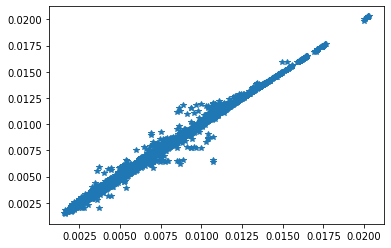

In [285]:
plt.plot(pred, train_y, "*")

In [287]:
pred = model.predict(test_x)

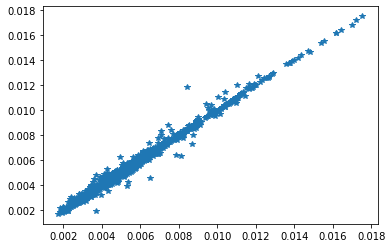

In [288]:
plt.plot(pred, test_y, "*")